In [61]:
from Experiment.detection import *

DMA = 'AB'
select_sensors = DMA_AB_sensors if DMA == 'AB' else DMA_C_sensors

with open(f"{File_PATH}/PUMP_AB_model.pickle", "rb") as f:
    models_DMA_AB = pickle.load(f)

models = models_DMA_AB

pump_flow_df = pd.read_csv("./pumps_diff_Q.csv")
pressure_df = pd.read_csv("./sensors_diff_P.csv")
# 第一列重命名为时间
pump_flow_df.rename(columns={pump_flow_df.columns[0]: "Timestamp"}, inplace=True)
pressure_df.rename(columns={pressure_df.columns[0]: "Timestamp"}, inplace=True)
# 时间列转换为时间类型
pump_flow_df["Timestamp"] = pd.to_datetime(pump_flow_df["Timestamp"])
pressure_df["Timestamp"] = pd.to_datetime(pressure_df["Timestamp"])
pump_flow_df.set_index("Timestamp", inplace=True)
pressure_df.set_index("Timestamp", inplace=True)

pump_flow = pump_flow_df["PUMP_1"]
pressure = pressure_df[select_sensors]


fix_pressure = pd.DataFrame(index=pressure.index, columns=pressure.columns)
pre_error = pd.DataFrame(0, index=pressure.index, columns=pressure.columns)

# 模型逐传感器预测
for sensor, model in models.items():
    pre = predict_pump_model(model, pressure[sensor], pump_flow, q=48)
    pre_error.loc[pre_error.index[-len(pre):], sensor] = pre
    fix_pressure[sensor] = pressure[sensor] - pre_error[sensor]
    print(f"{sensor} 修正完成")




D:\xiang\CX_application\Anconda3\envs\pytorch\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\xiang\CX_application\Anconda3\envs\pytorch\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


n54 修正完成
n105 修正完成
n114 修正完成
n163 修正完成
n188 修正完成
n288 修正完成
n296 修正完成
n332 修正完成
n342 修正完成
n410 修正完成
n415 修正完成
n429 修正完成
n458 修正完成
n469 修正完成
n495 修正完成
n506 修正完成
n516 修正完成
n519 修正完成
n549 修正完成
n613 修正完成
n636 修正完成
n644 修正完成
n679 修正完成
n722 修正完成
n726 修正完成
n740 修正完成
n752 修正完成
n769 修正完成
n215 修正完成
n229 修正完成


In [62]:

# FIS 参数
fis_params = init_fis_params(DMA)

In [63]:
fis_result, day_result_step, pressure_result = run(fix_pressure, fis_params, sensors=select_sensors)

In [64]:
leak_flag_times, detection_flag_times = collect_leak_detection_times(fis_result)

In [65]:
detection_flag_times

,time,sensors,max_leak_time
0,2018-01-03,"[n54, n114, n163, n188, n332, n342, n410, n415...",2018-01-03
1,2018-01-04,[n613],2018-01-04


In [66]:
inp_file = os.path.join(DATA_PATH, "L-TOWN_v2_Model.inp")

In [67]:
wn = wntr.network.WaterNetworkModel(inp_file)
# 管道坐标
pipe_coords = get_coordinate(wn)

In [68]:
leak_data = ["p657", "2018-01-03 13:30", "2018-01-06 23:55"],
leak_events = pd.DataFrame(leak_data, columns=["linkID", "startTime", "endTime"])
# 合并坐标
leak_info = leak_events.join(pipe_coords, on="linkID")
# 转换时间格式
leak_info["startTime"] = pd.to_datetime(leak_info["startTime"]).dt.normalize()
leak_info["endTime"] = pd.to_datetime(leak_info["endTime"]).dt.normalize()


In [69]:
max_leak = 5

In [70]:
leak_range = list(range(1, max_leak + 1))

In [71]:
times = detection_flag_times['time']
times

0   2018-01-03
1   2018-01-04
Name: time, dtype: datetime64[ns]

In [85]:
pressure_detection = fix_pressure.resample('D').mean().loc[times,:]

In [86]:
pipe_cluster_df = pd.read_csv(f"{File_PATH}/pipe_clusters.csv", index_col=0)
cluster_sens_df = pd.read_csv(f"{File_PATH}/cluster_sensitivity_vectors.csv", index_col=0)
with open(f"{File_PATH}/Sensitivity_Matrix.pickle",'rb') as f:
    sensor_sort = pickle.load(f)

In [87]:
leak_pipes = ['p657']

In [88]:

# --- 为该场景准备存放 k=1..max_leak 的反演结果 ---
residual_df = pd.DataFrame(index=times, columns=leak_range, dtype=float)
weights_df = pd.DataFrame(
    index=pipe_coords.index,
    columns=pd.MultiIndex.from_product([times, leak_range]),
    dtype=float
)
combination_df = pd.DataFrame(index=times, columns=leak_range, dtype=object)

# ------------- 3) 稀疏回归：算完所有 k（与 threshold 无关） -------------
max_p = 10

for t in times:
    # 当前时间的传感器观测
    v = pressure_detection.loc[t]

    # --- 选簇逻辑 ---
    pipe_max_sensor = sensor_sort.idxmax(axis=0)  # Series(index=pipe, value=最敏感传感器)
    p_eff = min(max_p, len(v))
    top_p_sensors = list(v.nlargest(p_eff).index)

    selected_clusters = []
    cluster_map = {}
    targer_cluster = list(set(pipe_cluster_df.loc[leak_pipes, "cluster"].tolist()))

    for c, group in pipe_cluster_df.groupby("cluster"):
        pipes_c = [pipe for pipe in group.index if pipe in sensor_sort.columns]
        if not pipes_c:
            continue

        hit = False
        for pipe in pipes_c:
            sensor_max = pipe_max_sensor.get(pipe, None)
            if sensor_max in top_p_sensors:
                hit = True
                break

        if hit:
            cluster_map[c] = pipes_c
            if c not in targer_cluster:
                selected_clusters.append(c)

    selected_num = min(max_p - len(leak_pipes), len(selected_clusters))
    clusters = targer_cluster + list(
        np.random.choice(selected_clusters, selected_num, replace=False)
    )
    print("choose clusters:", clusters)

    # --- 对每个 k=1..max_leak 做一次反演 ---
    for k in leak_range:
        combo, residual, weights = leak_probability_cluster(
            sensor_values=v,
            p=max_p,
            sensors=DMA_AB_sensors,
            lambda_=0.05,
            leak_count=k,
            algorithm='lasso',
            clusters=clusters,
            cluster_map=cluster_map,
        )

        # residual 统一成 float
        if isinstance(residual, (list, tuple, np.ndarray)):
            residual_val = float(residual[0])
        else:
            residual_val = float(residual)

        residual_df.at[t, k] = residual_val
        weights_df.loc[:, (t, k)] = (
            weights.reindex(pipe_coords.index)
            .fillna(0.0)
            .astype(float)
        )
        combination_df.at[t, k] = combo


choose clusters: [16, 3, 25, 4, 7, 1, 17, 22, 15, 12]
choose clusters: [16, 3, 24, 1, 8, 18, 17, 4, 19, 12]


In [89]:
residual_df

,1,2,3,4,5
time,,,,,
2018-01-03,0.983805,0.983805,0.983805,0.983805,0.983805
2018-01-04,1.153109,1.050345,1.048689,1.048684,1.048682


In [90]:

# ------------- 5) 对每一个 threshold 独立做“选 k + 评价” -------------
print("[RESULT]")
for thr in [0.2]:
    # 5.1 选 k
    best_k_series = pd.Series(index=times, dtype=int)
    best_weights_df = pd.DataFrame(index=pipe_coords.index, columns=times, dtype=float)
    best_combination_series = pd.Series(index=times, dtype=object)

    for t in times:
        res_row = residual_df.loc[t].fillna(np.inf)
        chosen_k = max_leak

        for k in range(2, max_leak + 1):
            prev, curr = res_row[k - 1], res_row[k]
            if not np.isfinite(prev) or not np.isfinite(curr):
                continue
            rel_drop = (prev - curr) / prev if prev != 0 else 0.0
            if rel_drop < thr:
                chosen_k = k - 1
                break

        best_k_series[t] = chosen_k
        best_weights_df.loc[:, t] = weights_df.loc[:, (t, chosen_k)]
        best_combination_series[t] = combination_df.at[t, chosen_k]

    # 5.2 计算泄漏中心 & 修正度 & 经济价值（对这个 threshold）
    leakage_center = compute_leakage_center(
        max_leak=max_leak,
        times=times,
        pipe_coords=pipe_coords,
        pipe_cluster_df=pipe_cluster_df,
        best_k_series=best_k_series,
        best_weights_df=best_weights_df,
        leak_info=leak_info,
    )

    detection_correction, _ = generate_detection_correction(
        leakage_center=leakage_center,
        leak_info=leak_info,
    )


[RESULT]


In [91]:
leakage_center

,time,center_id,x_center,y_center,distance,pipe,p657
0,2018-01-03,1,1349.565,525.335,[0.0],[p657],0.0
1,2018-01-04,1,1349.565,525.335,[0.0],[p657],0.0


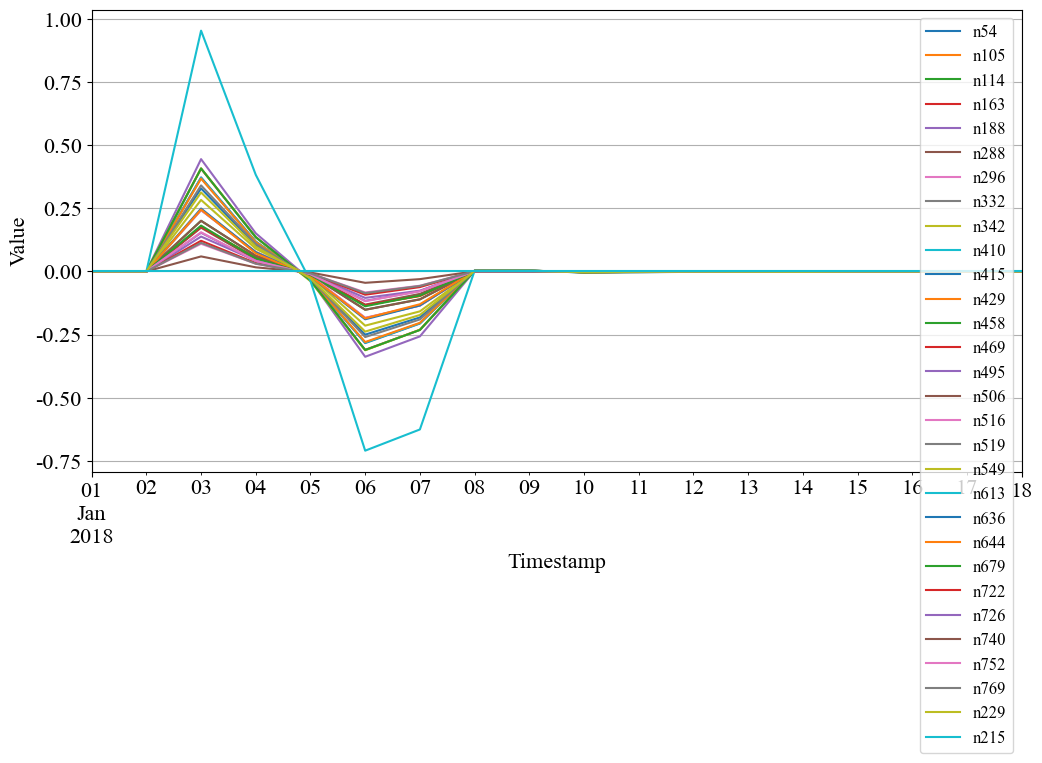

In [92]:
draw_plot(pressure_result)

In [79]:
fix_pressure

,n54,n105,n114,n163,n188,n288,n296,n332,n342,n410,...,n636,n644,n679,n722,n726,n740,n752,n769,n229,n215
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,-0.0003,-0.0000,-0.0000,-0.0000,-0.0001,-0.0001,-0.0000,-0.0000,-0.000100,0.002500,...,-0.0001,-0.0001,-0.0001,-0.0000,-0.0000,-0.0,-0.0000,-0.0000,-0.0001,0.0
2018-01-01 00:05:00,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.000000,-0.000100,...,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0,-0.0000,-0.0000,-0.0000,0.0
2018-01-01 00:10:00,-0.0000,-0.0000,-0.0000,-0.0001,-0.0001,-0.0000,-0.0000,-0.0000,-0.000100,-0.000100,...,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0,-0.0000,-0.0000,-0.0000,0.0
2018-01-01 00:15:00,-0.0001,-0.0000,-0.0000,-0.0001,-0.0001,-0.0000,-0.0000,-0.0001,-0.000100,-0.000100,...,-0.0001,-0.0001,-0.0000,-0.0000,-0.0000,-0.0,-0.0000,-0.0000,-0.0001,0.0
2018-01-01 00:20:00,-0.0001,-0.0001,-0.0001,-0.0001,-0.0001,-0.0000,-0.0000,-0.0001,-0.000100,-0.000100,...,-0.0001,-0.0001,-0.0000,-0.0000,-0.0000,-0.0,-0.0000,-0.0000,-0.0001,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-17 23:40:00,-0.0002,-0.0001,-0.0001,-0.0003,-0.0003,-0.0001,-0.0001,-0.0002,-0.000298,-0.000198,...,-0.0002,-0.0002,-0.0001,-0.0001,-0.0001,-0.0,-0.0001,-0.0001,-0.0002,0.0
2018-01-17 23:45:00,-0.0002,-0.0001,-0.0001,-0.0002,-0.0002,-0.0001,-0.0001,-0.0001,-0.000198,-0.000198,...,-0.0001,-0.0001,-0.0001,-0.0001,-0.0001,-0.0,-0.0001,-0.0001,-0.0002,0.0
2018-01-17 23:50:00,-0.0001,-0.0001,-0.0001,-0.0002,-0.0002,-0.0001,-0.0000,-0.0001,-0.000098,-0.000098,...,-0.0001,-0.0001,-0.0001,-0.0000,-0.0001,-0.0,-0.0001,-0.0000,-0.0001,0.0
